# Flow Matching MNIST

<a target="_blank" href="https://colab.research.google.com/github/cgarciae/simple_flow_matching/blob/main/notebooks/mnist_dit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [9]:
#! pip install -Uq einop diffrax stop_iter treescope git+https://github.com/google/flax.git@nnx-tabulate
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np
from einop import einop
from IPython.display import clear_output
from stop_iter import stop_iter
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

clear_output()

X.shape = (70000, 28, 28, 1)
Y.shape = (70000,)


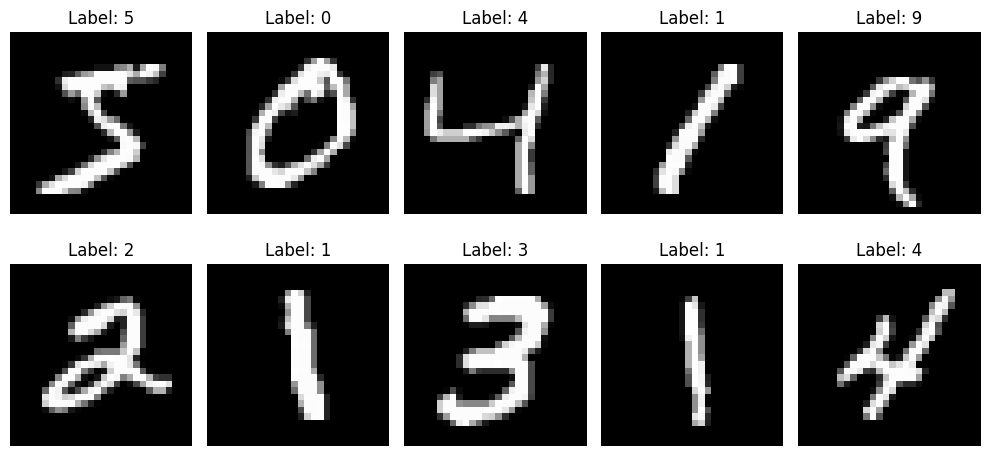

In [2]:
# Load data from openml
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)

# Extract data and labels
X = mnist.data.astype("uint8").reshape(-1, 28, 28, 1)
Y = mnist.target.astype("uint8")

# Normalize data
X = (X / 255.0) * 2 - 1

print(f"{X.shape = }")
print(f"{Y.shape = }")

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(X[i].squeeze(), cmap="gray")
  ax.set_title(f"Label: {Y[i]}")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
class TimestepEmbedder(nnx.Module):
  def __init__(
    self,
    hidden_size: int,
    frequency_embedding_size: int = 256,
    *,
    rngs: nnx.Rngs,
  ):
    self.hidden_size = hidden_size
    self.frequency_embedding_size = frequency_embedding_size
    kernel_init = nnx.initializers.normal(0.02)
    self.linear1 = nnx.Linear(
      frequency_embedding_size, hidden_size, kernel_init=kernel_init, rngs=rngs
    )
    self.linear2 = nnx.Linear(
      hidden_size, hidden_size, kernel_init=kernel_init, rngs=rngs
    )

  # def __call__(self, t):
  #   x = self.timestep_embedding(t)
  #   x = nn.Dense(self.hidden_size, kernel_init=nn.initializers.normal(0.02))(x)
  #   x = nn.silu(x)
  #   x = nn.Dense(self.hidden_size, kernel_init=nn.initializers.normal(0.02))(x)
  #   return x

  def __call__(self, t):
    x = self.timestep_embedding(t)
    return self.linear2(nnx.silu(self.linear1(x)))

  def timestep_embedding(self, t, max_period=10000):
    t = jax.lax.convert_element_type(t, jnp.float32)
    t = t * max_period
    dim = self.frequency_embedding_size
    half = dim // 2
    freqs = jnp.exp(
      -jnp.log(max_period) * jnp.arange(start=0, stop=half, dtype=jnp.float32) / half
    )
    args = t[:, None] * freqs[None]
    embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
    return embedding


class LabelEmbedder(nnx.Module):
  def __init__(
    self,
    dropout_prob: float,
    num_classes: int,
    hidden_size: int,
    deterministic: bool = False,
    *,
    rngs: nnx.Rngs,
  ):
    self.dropout_prob = dropout_prob
    self.num_classes = num_classes
    self.hidden_size = hidden_size
    self.deterministic = deterministic
    self.rngs = rngs
    self.embedding_table = nnx.Embed(
      self.num_classes + 1,
      self.hidden_size,
      embedding_init=nnx.initializers.normal(0.02),
      rngs=rngs,
    )

  def token_drop(self, labels, *, force_drop_ids=None):
    if force_drop_ids is None:
      rng = self.rngs.label_dropout()
      drop_ids = jax.random.bernoulli(rng, self.dropout_prob, (labels.shape[0],))
    else:
      drop_ids = force_drop_ids == 1
    labels = jnp.where(drop_ids, self.num_classes, labels)
    assert isinstance(labels, jax.Array)
    return labels

  def __call__(self, labels: jax.Array, *, force_drop_ids=None):
    if (not self.deterministic and self.dropout_prob > 0) or (
      force_drop_ids is not None
    ):
      labels = self.token_drop(labels, force_drop_ids=force_drop_ids)
    embeddings = self.embedding_table(labels)
    return embeddings


class MlpBlock(nnx.Module):
  def __init__(
    self,
    din: int,
    mlp_dim: int,
    dtype: jnp.dtype = jnp.float32,
    out_dim: int | None = None,
    dropout_rate: float | None = None,
    kernel_init: nnx.Initializer = nnx.initializers.xavier_uniform(),
    bias_init: nnx.Initializer = nnx.initializers.normal(stddev=1e-6),
    *,
    rngs: nnx.Rngs,
  ):
    self.mlp_dim = mlp_dim
    self.dtype = dtype
    self.out_dim = out_dim
    self.dropout_rate = dropout_rate
    self.kernel_init = kernel_init
    self.bias_init = bias_init
    self.rngs = rngs
    self.linear1 = nnx.Linear(
      din,
      self.mlp_dim,
      dtype=self.dtype,
      kernel_init=self.kernel_init,
      bias_init=self.bias_init,
      rngs=self.rngs,
    )
    self.linear2 = nnx.Linear(
      self.mlp_dim,
      self.out_dim if self.out_dim is not None else din,
      dtype=self.dtype,
      kernel_init=self.kernel_init,
      bias_init=self.bias_init,
      rngs=self.rngs,
    )

  def __call__(self, inputs: jax.Array):
    x = nnx.gelu(self.linear1(inputs))
    # x = nn.Dropout(rate=self.dropout_rate)(x)
    output = self.linear2(x)
    # output = nn.Dropout(rate=self.dropout_rate)(output)
    return output


class PatchEmbed(nnx.Module):
  """2D Image to Patch Embedding"""

  def __init__(
    self,
    din: int,
    patch_size: int,
    embed_dim: int,
    bias: bool = True,
    *,
    rngs: nnx.Rngs,
  ):
    self.din = din
    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.bias = bias
    self.rngs = rngs
    self.conv = nnx.Conv(
      din,
      embed_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      use_bias=bias,
      padding="VALID",
      kernel_init=nnx.initializers.xavier_uniform(),
      rngs=rngs,
    )

  def __call__(self, x: jax.Array):
    x = self.conv(x)  # (B, P, P, hidden_size)
    x = einop(x, "b h w c -> b (h w) c")
    return x


def modulate(x, shift, scale):
  return x * (1 + scale[:, None]) + shift[:, None]


# From https://github.com/young-geng/m3ae_public/blob/master/m3ae/model.py
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
  assert embed_dim % 2 == 0
  omega = jnp.arange(embed_dim // 2, dtype=jnp.float32)
  omega /= embed_dim / 2.0
  omega = 1.0 / 10000**omega  # (D/2,)

  pos = pos.reshape(-1)  # (M,)
  out = jnp.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

  emb_sin = jnp.sin(out)  # (M, D/2)
  emb_cos = jnp.cos(out)  # (M, D/2)

  emb = jnp.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
  return emb


def get_1d_sincos_pos_embed(embed_dim, length):
  return jnp.expand_dims(
    get_1d_sincos_pos_embed_from_grid(embed_dim, jnp.arange(length, dtype=jnp.float32)),
    0,
  )


def get_2d_sincos_pos_embed(rng, embed_dim, length):
  # example: embed_dim = 256, length = 16*16
  grid_size = int(length**0.5)
  assert grid_size * grid_size == length

  def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = jnp.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

  grid_h = jnp.arange(grid_size, dtype=jnp.float32)
  grid_w = jnp.arange(grid_size, dtype=jnp.float32)
  grid = jnp.meshgrid(grid_w, grid_h)  # here w goes first
  grid = jnp.stack(grid, axis=0)
  grid = grid.reshape([2, 1, grid_size, grid_size])
  pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
  return jnp.expand_dims(pos_embed, 0)  # (1, H*W, D)


################################################################################
#                                 Core DiT Model                                #
#################################################################################


class DiTBlock(nnx.Module):
  """
  A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
  """

  def __init__(
    self,
    hidden_size,
    num_heads,
    mlp_ratio=4.0,
    *,
    rngs: nnx.Rngs,
  ):
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.mlp_ratio = mlp_ratio
    self.linear1 = nnx.Linear(
      hidden_size,
      6 * hidden_size,
      kernel_init=nnx.initializers.constant(0.0),
      rngs=rngs,
    )
    self.ln1 = nnx.LayerNorm(hidden_size, use_bias=False, use_scale=False, rngs=rngs)
    self.attention = nnx.MultiHeadAttention(
      num_heads, hidden_size, kernel_init=nnx.initializers.xavier_uniform(), decode=False, rngs=rngs
    )
    self.ln2 = nnx.LayerNorm(hidden_size, use_bias=False, use_scale=False, rngs=rngs)
    self.mlp_block = MlpBlock(
      hidden_size, mlp_dim=int(self.hidden_size * self.mlp_ratio), rngs=rngs
    )

  def __call__(self, x: jax.Array, c: jax.Array):
    # Calculate adaLn modulation parameters.
    c = nnx.silu(c)
    c = self.linear1(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = jnp.split(
      c, 6, axis=-1
    )

    # Attention Residual.
    x_norm = self.ln1(x)
    x_modulated = modulate(x_norm, shift_msa, scale_msa)
    attn_x = self.attention(x_modulated)
    x = x + (gate_msa[:, None] * attn_x)

    # MLP Residual.
    x_norm2 = self.ln2(x)
    x_modulated2 = modulate(x_norm2, shift_mlp, scale_mlp)
    mlp_x = self.mlp_block(x_modulated2)
    x = x + (gate_mlp[:, None] * mlp_x)
    return x


class FinalLayer(nnx.Module):
  """
  The final layer of DiT.
  """

  def __init__(
    self,
    patch_size: int,
    out_channels: int,
    hidden_size: int,
    *,
    rngs: nnx.Rngs,
  ):
    self.patch_size = patch_size
    self.out_channels = out_channels
    self.hidden_size = hidden_size
    self.linear1 = nnx.Linear(
      hidden_size,
      2 * hidden_size,
      kernel_init=nnx.initializers.constant(0.0),
      rngs=rngs,
    )
    self.ln1 = nnx.LayerNorm(hidden_size, use_bias=False, use_scale=False, rngs=rngs)
    self.linear2 = nnx.Linear(
      hidden_size,
      self.patch_size * self.patch_size * self.out_channels,
      kernel_init=nnx.initializers.constant(0),
      rngs=rngs,
    )

  # @nn.compact
  # def __call__(self, x, c):
  #   c = nn.silu(c)
  #   c = nn.Dense(2 * self.hidden_size, kernel_init=nn.initializers.constant(0))(c)
  #   shift, scale = jnp.split(c, 2, axis=-1)
  #   x = modulate(nn.LayerNorm(use_bias=False, use_scale=False)(x), shift, scale)
  #   x = nn.Dense(
  #     self.patch_size * self.patch_size * self.out_channels,
  #     kernel_init=nn.initializers.constant(0),
  #   )(x)
  #   return x

  def __call__(self, x: jax.Array, c: jax.Array):
    c = nnx.silu(c)
    c = self.linear1(c)
    shift, scale = jnp.split(c, 2, axis=-1)
    x = modulate(self.ln1(x), shift, scale)
    x = self.linear2(x)
    return x


class DiT(nnx.Module):
  """
  Diffusion model with a Transformer backbone.
  """

  patch_size: int
  hidden_size: int
  depth: int
  num_heads: int
  mlp_ratio: float
  class_dropout_prob: float
  num_classes: int
  learn_sigma: bool = False

  def __init__(
    self,
    in_channels: int,
    input_size: int,  # assume square image
    patch_size: int,
    hidden_size: int,
    depth: int,
    num_heads: int,
    mlp_ratio: float,
    class_dropout_prob: float,
    num_classes: int,
    learn_sigma: bool = False,
    *,
    rngs: nnx.Rngs,
  ):
    self.in_channels = in_channels
    self.input_size = input_size
    self.patch_size = patch_size
    self.hidden_size = hidden_size
    self.depth = depth
    self.num_heads = num_heads
    self.mlp_ratio = mlp_ratio
    self.class_dropout_prob = class_dropout_prob
    self.num_classes = num_classes
    self.learn_sigma = learn_sigma
    self.num_patches = (input_size // self.patch_size) ** 2
    self.out_channels = in_channels if not self.learn_sigma else in_channels * 2
    self.num_patches = (input_size // self.patch_size) ** 2
    self.num_patches_side = input_size // self.patch_size
    self.pos_embed = nnx.Param(
      get_2d_sincos_pos_embed(rngs.params(), self.hidden_size, self.num_patches)
    )
    self.patch_embed = PatchEmbed(
      self.in_channels, self.patch_size, self.hidden_size, rngs=rngs
    )
    self.timestep_embedder = TimestepEmbedder(self.hidden_size, rngs=rngs)
    self.label_embedder = LabelEmbedder(
      self.class_dropout_prob, self.num_classes, self.hidden_size, rngs=rngs
    )
    self.blocks = [
      DiTBlock(self.hidden_size, self.num_heads, self.mlp_ratio, rngs=rngs)
      for _ in range(self.depth)
    ]
    self.final_layer = FinalLayer(
      self.patch_size, self.out_channels, self.hidden_size, rngs=rngs
    )

  def __call__(
    self, *, x: jax.Array, t: jax.Array, y: jax.Array | None = None, force_drop_ids=None
  ):
    # (x = (B, H, W, C) image, t = (B,) timesteps, y = (B,) class labels)
    # print("DiT: Input of shape", x.shape)
    batch_size = x.shape[0]
    pos_embed = jax.lax.stop_gradient(self.pos_embed.value)
    x = self.patch_embed(x)  # (B, num_patches, hidden_size)
    # print("DiT: After patch embed, shape is", x.shape)
    x = x + pos_embed
    t = self.timestep_embedder(t)  # (B, hidden_size)
    if y is not None:
      y = self.label_embedder(y, force_drop_ids=force_drop_ids)  # (B, hidden_size)
      c = t + y
    else:
      c = t

    # print("DiT: Patch Embed of shape", x.shape)
    # print("DiT: Pos Embedding of shape", pos_embed.shape)
    # print("DiT: Timestep Embedding of shape", t.shape)
    # print("DiT: Label Embedding of shape", y.shape)

    for block in self.blocks:
      x = block(x, c)
      # print("DiT: DiTBlock of shape", x.shape)
    x = self.final_layer(x, c)  # (B, num_patches, p*p*c)
    # print("DiT: FinalLayer of shape", x.shape)
    x = jnp.reshape(
      x,
      (
        batch_size,
        self.num_patches_side,
        self.num_patches_side,
        self.patch_size,
        self.patch_size,
        self.out_channels,
      ),
    )
    x = einop(x, "B H W P Q C -> B (H P) (W Q) C")
    assert x.shape == (batch_size, self.input_size, self.input_size, self.out_channels)
    return x

  @nnx.jit
  def step(self, x: jax.Array, t_start: jax.Array, t_end: jax.Array) -> jax.Array:
    t_start = jnp.full(x.shape[0], t_start)[:, None]

    x_t1 = x + self(x=x, t=t_start) * (t_end - t_start) / 2
    return x + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x=x_t1)


rngs = nnx.Rngs(0)
# --dataset_name imagenet256 --wandb.name DiT-B --model.depth 12 --model.hidden_size 768 --model.patch_size 2 --model.num_heads 16 --model.mlp_ratio 4 --batch_size 512
flow = DiT(
  in_channels=1,
  input_size=28,
  patch_size=2,
  hidden_size=512,
  depth=6,
  num_heads=8,
  mlp_ratio=4,
  class_dropout_prob=0.1,
  num_classes=10,
  learn_sigma=False,
  rngs=rngs,
)
optimizer = nnx.Optimizer(flow, tx=optax.adamw(1e-4))

dx_t = flow(x=jnp.ones((1, 28, 28, 1)), t=jnp.ones((1,)))
print(f"{dx_t.shape = }")
print(nnx.tabulate(flow, depth=2))
nnx.display(flow)

dx_t.shape = (1, 28, 28, 1)


                                       DiT Summary                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path                           ┃ type      ┃ Param                         ┃ RngState ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│                                │ DiT       │ pos_embed: float32[1,196,512] │          │
│                                │           │                               │          │
│                                │           │ 100,352 (401.4 KB)            │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/0                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │ 2 (12 B) │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/1                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/2                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/3                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/4                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ blocks/5                       │ DiTBlock  │ 4,726,272 (18.9 MB)           │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ final_layer/linear1            │ Linear    │ bias: float32[1024]           │          │
│                                │           │ kernel: float32[512,1024]     │          │
│                                │           │                               │          │
│                                │           │ 525,312 (2.1 MB)              │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ final_layer/linear2            │ Linear    │ bias: float32[4]              │          │
│                                │           │ kernel: float32[512,4]        │          │
│                                │           │                               │          │
│                                │           │ 2,052 (8.2 KB)                │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ final_layer/ln1                │ LayerNorm │                               │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ label_embedder/embedding_table │ Embed     │ embedding: float32[11,512]    │          │
│                                │           │                               │          │
│                                │           │ 5,632 (22.5 KB)               │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ patch_embed/conv               │ Conv      │ bias: float32[512]            │          │
│                                │           │ kernel: float32[2,2,1,512]    │          │
│                                │           │                               │          │
│                                │           │ 2,560 (10.2 KB)               │          │
├────────────────────────────────┼───────────┼───────────────────────────────┼──────────┤
│ timestep_embedder/linear1      │ Linear    │ bias: float32[512]            │          │
│                                │           │ kernel: float32[256,512]      │          │
│                                │           │                               │          │
│                                │      

In [4]:
from matplotlib.figure import Figure


def plot_sample(fig: Figure, *, n_steps=8):
  x = np.random.randn(1, *X.shape[1:])

  axes = fig.subplots(2, (n_steps) // 2 + 1, sharex=True, sharey=True)
  time_steps = np.linspace(0, 1.0, n_steps + 1)

  for i, ax in enumerate(axes.flat):
    if i == 0:
      ax.imshow(x.squeeze(), cmap="gray")
      ax.set_title(f"t = {time_steps[0]:.2f}")
    elif i <= n_steps:
      x = flow.step(x=x, t_start=time_steps[i - 1], t_end=time_steps[i])
      ax.imshow(x.squeeze(), cmap="gray")
      ax.set_title(f"t = {time_steps[i]:.2f}")
    ax.axis("off")

  fig.tight_layout()

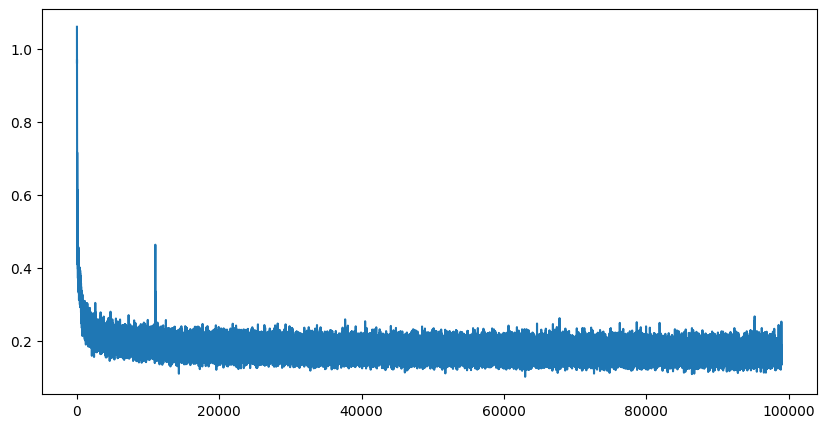

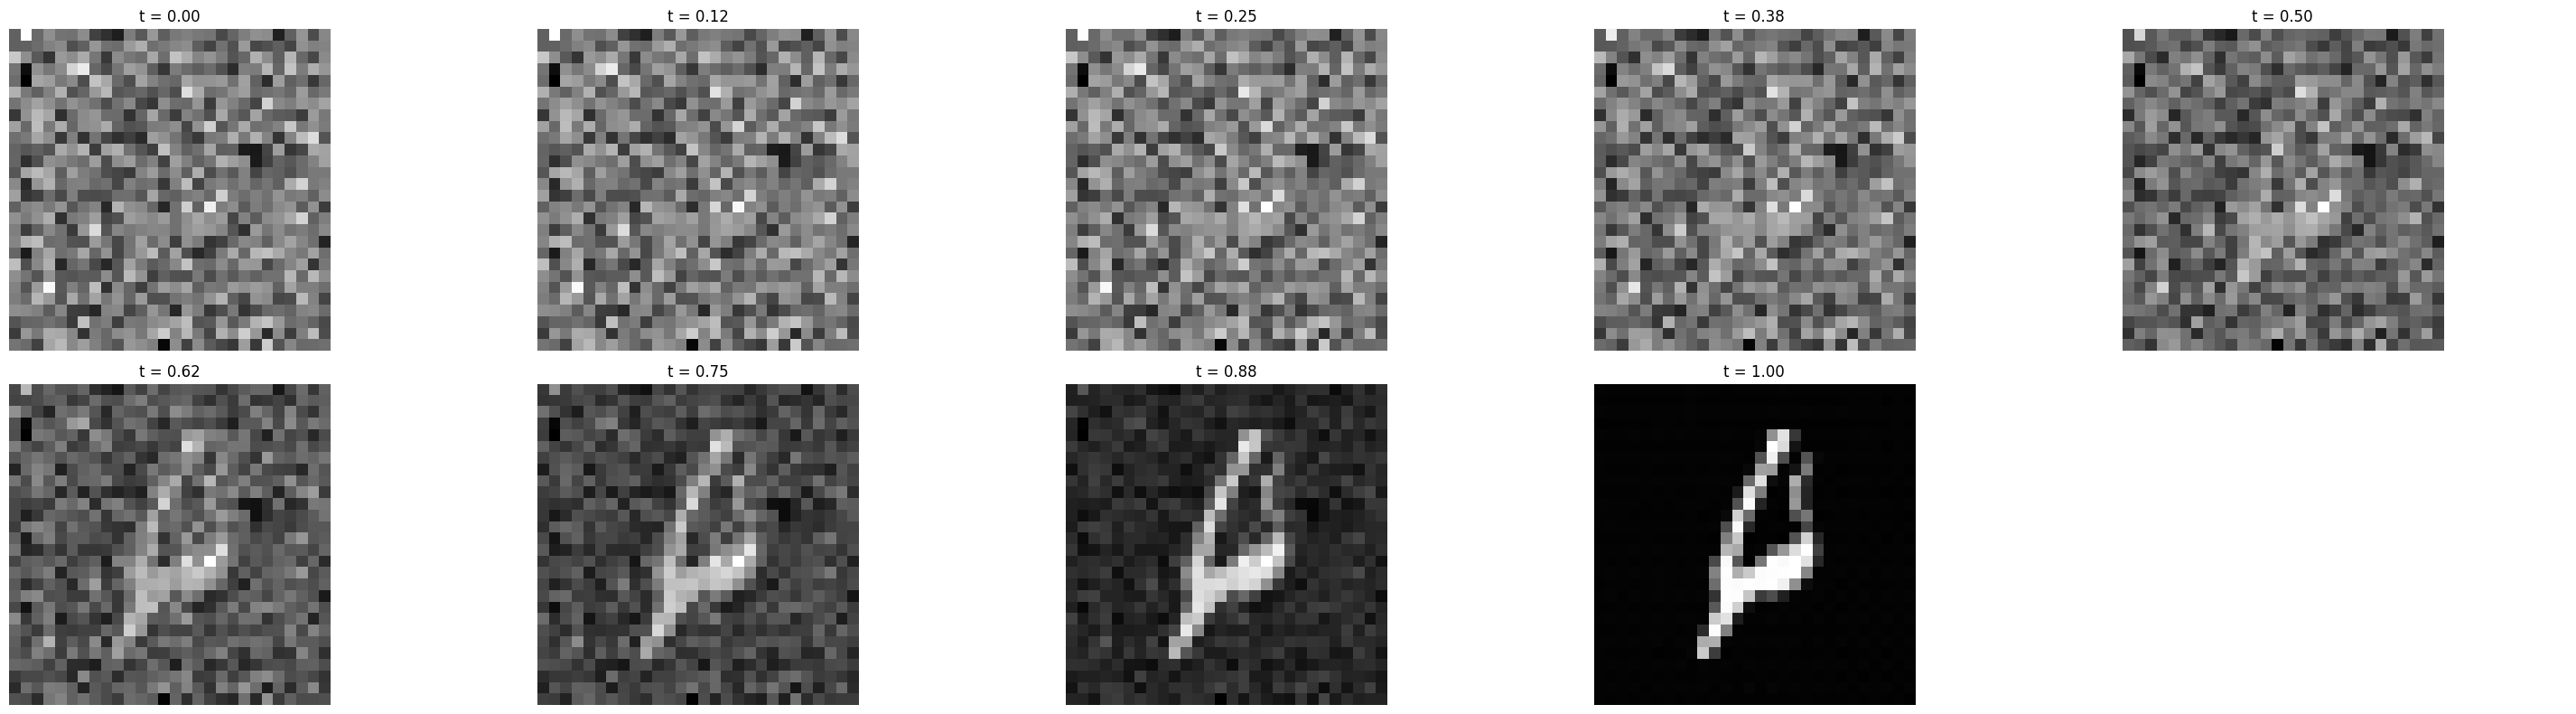

100%|██████████| 100000/100000 [1:04:37<00:00, 25.79it/s]


In [5]:
mse = lambda a, b: jnp.mean((a - b) ** 2)


@nnx.jit(donate_argnums=(0, 1, 2))
def train_step(flow, optimizer, rngs, x_1):
  x_0 = jax.random.normal(rngs(), x_1.shape)
  t = jax.random.uniform(rngs(), (len(x_1),))

  x_t = jax.vmap(lambda x_0, x_1, t: (1 - t) * x_0 + t * x_1)(x_0, x_1, t)
  dx_t = x_1 - x_0

  loss, grads = nnx.value_and_grad(lambda flow: mse(flow(x=x_t, t=t), dx_t))(flow)
  optimizer.update(grads)
  return loss


losses = []
plot_interval = 60
t0 = time.time()
for step in stop_iter(tqdm(range(100_000))):
  x_1 = X[np.random.choice(len(X), 32)]
  loss = train_step(flow, optimizer, rngs, x_1)
  losses.append(np.asarray(loss))
  if step == 0 or time.time() - t0 >= plot_interval:
    if step > 0:
      t0 = time.time()
    # plot loss
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(losses[100:])
    # plot samples
    plot_sample(plt.figure(figsize=(30, 8)))
    plt.show()

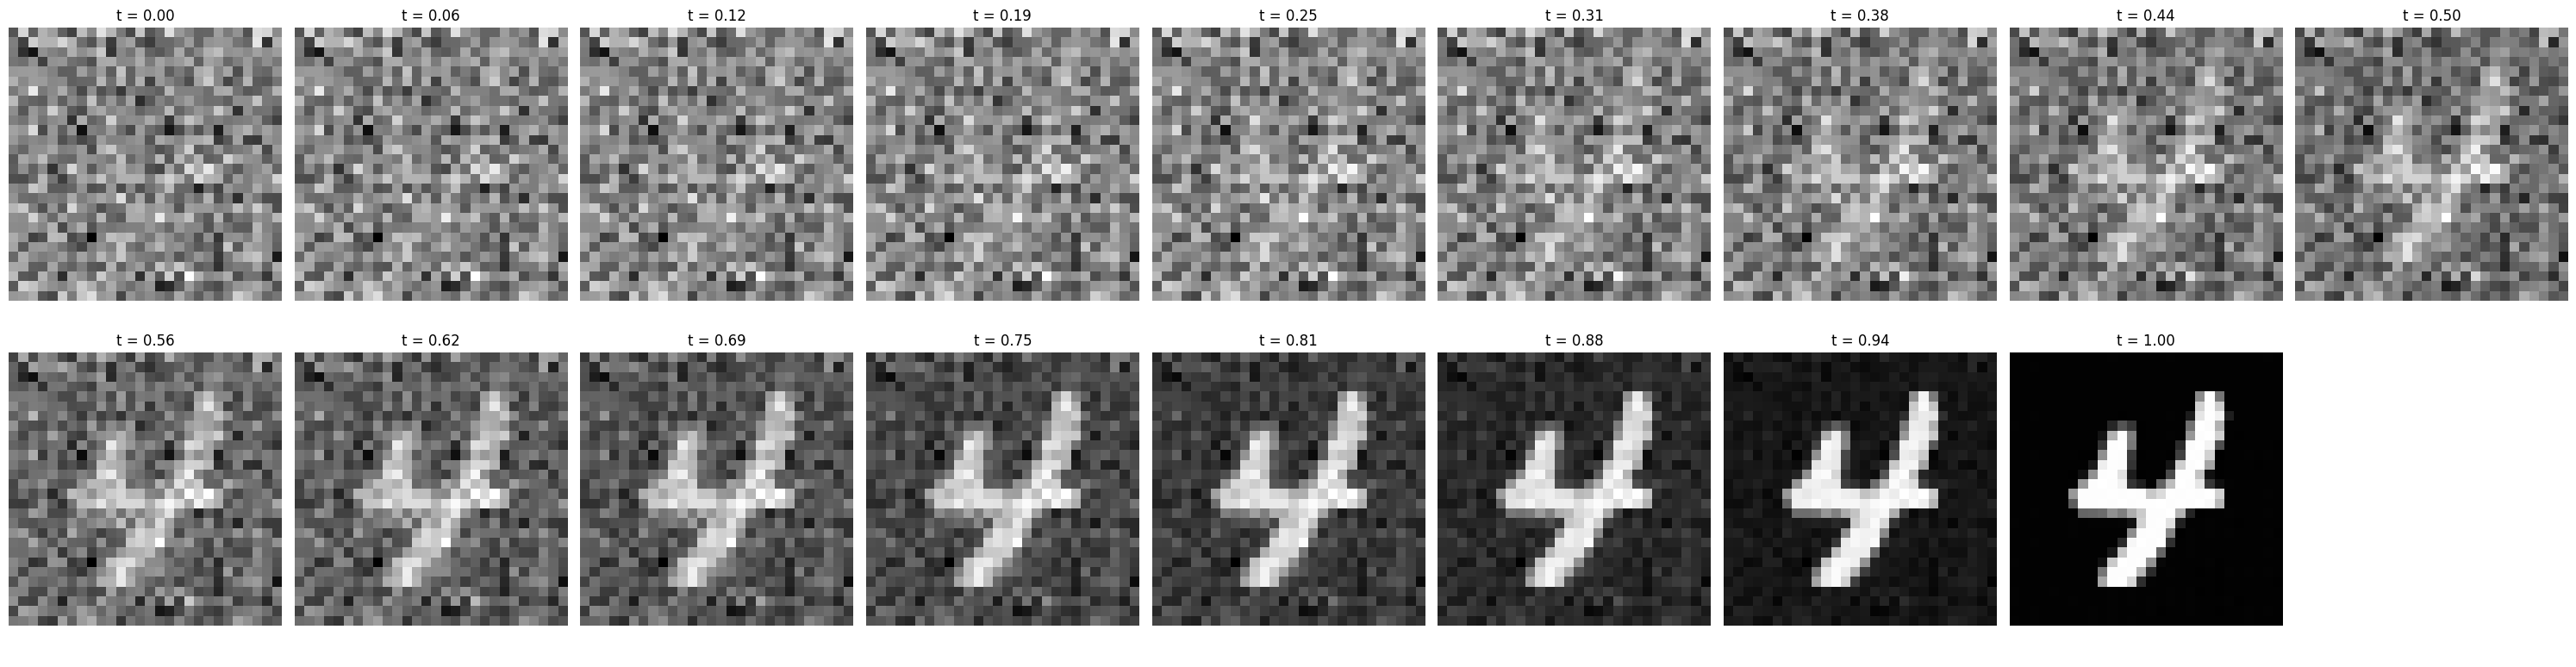

In [8]:
plot_sample(plt.figure(figsize=(30, 8)), n_steps=16)
plt.show()